In [357]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import skewnorm, rankdata

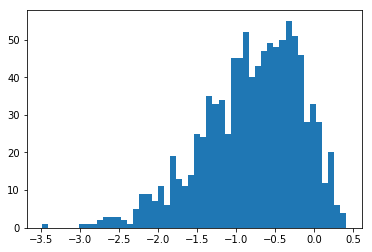

In [334]:
X = skewnorm.rvs(a=-5,size=1000)
plt.hist(X, bins=50)
plt.show()

work  in bayesian vs frequentist thinking
p values, priors etc.

logistic regression (over/under x hours?) to discuss ROC

In [480]:
class createSet(object): # Make this subclass pd dataframe? #https://stackoverflow.com/questions/22155951/how-to-subclass-pandas-dataframe
    def __init__(self,size=10000, targetskew=0, addCorrFeats=True):
        self.size = size
        self.cons = 1
        self.cats = 1
        targetMean = 6000
        targetStd = 2000
        self.hoursSpent = skewnorm.rvs(a=targetskew,loc=targetMean,scale=targetStd, size=self.size)
        sortedNormal = np.sort(skewnorm.rvs(a=0, loc=targetMean,scale=targetStd, size=self.size))
        self.normWithTargetSorting = [sortedNormal[i-1] for i in rankdata(self.hoursSpent, method='ordinal')]
        
        df = pd.DataFrame(self.hoursSpent, columns=['hoursSpent'])
        if addCorrFeats == True:
            #This adds a normally distributed feature that's typically around .65 correlation
            df['screenActions'] = [int(x+np.random.randint(low=(targetMean - targetStd*2),
                                    high=(targetMean + targetStd*2))) for x in self.normWithTargetSorting]
            
            #This adds a uniformly distributed feature that's typically around .13 correlation
            def unif(self, p):
                return np.random.choice(a=[np.random.uniform(high=150),np.random.uniform(low=150.1,high=300)], p=p)
            df ['picsPerMonth'] = [unif(self,[.4,.6]) if x > targetMean else 
                                   unif(self,[.6,.4]) for x in self.normWithTargetSorting]
            
            #This adds a poisson distribution that's typically around .17 correlation
            df['timesDropped'] = [np.random.poisson(lam=1.5) if x > targetMean else 
                                  np.random.poisson(lam=1.0) for x in self.normWithTargetSorting]
            
            #This adds a dual-peak gamma distribution for owner age, typically around -.12 correlation
            def gam(self, p):
                return np.random.choice(a=[np.random.gamma(shape=25.0,scale=1),
                              np.random.gamma(shape=25.0,scale=1.8)], p=p)
            df['ownerAge'] = [gam(self,[.6,.4]) if x >targetMean else 
                              gam(self,[.4,.6]) for x in self.normWithTargetSorting]
            
            #This adds a bernoulli distribution for whether the phone is rooted, typically around .06 correlation
            df['rooted'] = [np.random.binomial(1, .05) if x > targetMean*1.5 else
                            np.random.binomial(1, .005) for x in self.normWithTargetSorting]
            
            #This adds a categorical variable that slightly corresponds to the target
            def osChoice(self, p):
                return np.random.choice(a=['iOS', 'Android', 'other'], p=p)
            df ['os'] = [osChoice(self,[.415,.575,.01]) if x > targetMean else 
                                   osChoice(self,[.335,.635,.03]) for x in self.normWithTargetSorting]
               
        self.df = df
        
    def addContFeatures(self, feats={'normal':1}):
        for shape, cnt in feats.items():
            if shape == 'normal':
                for j in range(cnt):
                    Y = np.random.normal(loc=targetMean,scale=targetStd, size=self.size)
                    self.df['normalFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'uniform':
                for j in range(cnt):
                    Y = np.random.uniform(size=self.size)*(targetMean*2)
                    self.df['uniformFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'poisson':
                for j in range(cnt):
                    Y = np.random.poisson(lam=1.0,size=self.size)
                    self.df['poissonFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'gamma':
                for j in range(cnt):
                    Y = np.random.gamma(shape=2.0,scale=2,size=self.size)
                    self.df['gammaFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
                    
                
            else:
                print('NOTE: received invalid distribution type. Try \"normal\", \"uniform\", or ')
    
    def addCatFeatures(self, feats={'sex':['male', 'female']}):
        for name, values in feats.items():
            odds = np.random.randint(low=0, high=len(values),size=self.size)
            self.df[name] = [values[x] for x in odds]
            del odds
            
    def addOutliers(self, cnt=5):
        #code this
        self.df = df
        
        
        
            
        

done in  0.7917022705078125 seconds


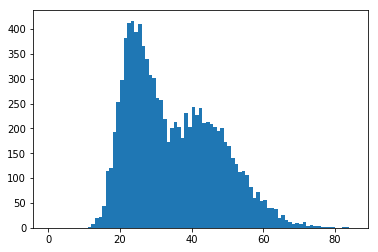

In [481]:
start = time.time()
u = createSet(size=10000)
print('done in ', time.time() - start, 'seconds')
plt.hist(u.df.ownerAge, bins=np.arange(0,max(u.df.ownerAge),1))
plt.show()

In [483]:
import time
start = time.time()
screencorrs = []
picscorrs = []
dropscorrs = []
agecorrs = []
rootcorrs = []
for i in range(100):
    u = createSet(size=1000)
    cor = u.df.corr()
    screencorrs.append(cor.loc['hoursSpent','screenActions'])
    picscorrs.append(cor.loc['hoursSpent','picsPerMonth'])
    dropscorrs.append(cor.loc['hoursSpent','timesDropped'])
    agecorrs.append(cor.loc['hoursSpent','ownerAge'])
    rootcorrs.append(cor.loc['hoursSpent','rooted'])
print('Correlations: \n')
print('screenActions\n',np.mean(screencorrs),'\n', np.std(screencorrs), '\n')
print('picsPerMonth\n',np.mean(picscorrs),'\n', np.std(picscorrs), '\n')
print('timesDropped\n',np.mean(dropscorrs),'\n', np.std(dropscorrs), '\n')
print('ownerAge\n',np.mean(agecorrs),'\n', np.std(agecorrs), '\n')
print('rooted\n',np.mean(rootcorrs),'\n', np.std(rootcorrs), '\n')
print('done in ', time.time() - start, 'seconds')


Correlations: 

screenActions
 0.6529936360534075 
 0.017595004459909698 

picsPerMonth
 0.13919151988552142 
 0.032801651067367155 

timesDropped
 0.1703013678047096 
 0.025884462096022357 

ownerAge
 -0.12565313044235832 
 0.035904113295064564 

rooted
 0.06538264516559424 
 0.04432804813878353 

done in  8.858856916427612 seconds


In [414]:
take = createSet()
print(take.df.shape)
take.df.corr()

(10000, 7)


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted
hoursSpent,1.000000,0.663871,0.150017,0.175142,-0.551539,0.072646
screenActions,0.663871,1.000000,0.092898,0.111480,-0.364373,0.040623
picsPerMonth,0.150017,0.092898,1.000000,0.034026,-0.130418,0.013333
timesDropped,0.175142,0.111480,0.034026,1.000000,-0.149807,0.000955
ownerAge,-0.551539,-0.364373,-0.130418,-0.149807,1.000000,-0.023835
rooted,0.072646,0.040623,0.013333,0.000955,-0.023835,1.000000


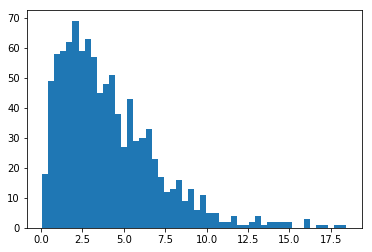

In [126]:
take.addContFeatures({'gamma':1})
plt.hist(take.df.gammaFeat_1, bins=50)
plt.show()

In [144]:
take.addContFeatures(feats={'normal':1, 'uniform':1, 'poisson':1})
print(take.df.shape)
take.df.head()

(1000, 6)


,hoursSpent,screenActions,timesDropped,normalFeat_1,uniformFeat_2,poissonFeat_3
0,7025.768187,13779,16,3488.864755,1241.739767,0
1,4744.323394,13440,28,3306.493388,11380.582651,0
2,6465.886713,8957,18,6360.868781,11944.358398,1
3,4677.382509,11358,16,11718.625313,11129.623893,0
4,7343.205618,16074,15,6918.779239,1409.188442,2


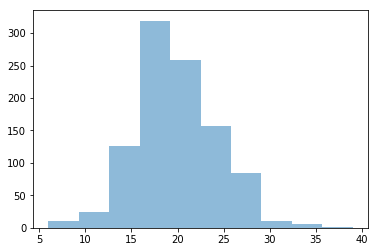

In [59]:
#plt.hist(take.df.normalFeat_2, alpha=.5)
plt.hist(take.df.poissonFeat_6, alpha = .5)
plt.show()

In [394]:
take.addCatFeatures(feats={'gender':['male', 'female'], 'student':['student', 'nonstudent']})
take.df.head(10)

,hoursSpent,screenActions,normalFeat_1,normalFeat_2,uniformFeat_3,uniformFeat_4,poissonFeat_5,poissonFeat_6,gender,student
0,4726.680872,7239,3318.733283,6760.883202,2793.399787,7780.412519,0,2,male,student
1,7652.864362,14193,8980.967883,4536.192327,6529.965714,10078.343586,1,0,male,nonstudent
2,5060.232892,10829,7703.967158,6478.884815,4705.806357,10791.209898,0,0,male,nonstudent
3,2924.658787,10965,6393.785575,4975.838486,2703.983174,2314.478986,0,1,female,student
4,5911.015493,12878,7265.351597,6916.448047,1891.778779,266.917580,1,0,male,student
5,5743.715900,11990,7345.968604,6125.664308,11938.108752,4827.002978,3,2,male,nonstudent
6,4204.863186,9359,3451.650470,6075.786310,8987.158555,1697.810369,3,1,male,nonstudent
7,4750.183253,12278,6588.038070,6783.890474,932.321707,9684.857858,0,2,female,student
8,9607.308577,13018,5234.228845,3351.095350,9850.004830,8694.898137,1,0,male,nonstudent
9,6943.741146,10986,6631.441372,5668.765396,9344.298894,11920.909157,1,1,female,student


In [352]:
take.df.groupby(['gender', 'student']).agg('count')

hoursSpent  screenActions  normalFeat_1  normalFeat_2  \
gender student                                                             
female nonstudent         251            251           251           251   
       student            258            258           258           258   
male   nonstudent         272            272           272           272   
       student            219            219           219           219   

                   normalFeat_3  normalFeat_4  normalFeat_5  
gender student                                               
female nonstudent           251           251           251  
       student              258           258           258  
male   nonstudent           272           272           272  
       student              219           219           219

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

_________________

In [487]:
take = createSet(targetskew=10)
print(take.df.shape)
display(take.df.head())
take.df.corr()

(10000, 7)


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted,os
0,5755.643846,10214,139.568722,0,32.183201,0,iOS
1,6849.254555,7448,121.059805,1,34.318904,0,Android
2,7026.139404,12905,136.725841,0,46.302357,0,Android
3,7475.100915,10319,213.286251,1,29.349537,0,iOS
4,6873.912233,9987,57.612994,1,45.738262,0,iOS


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted
hoursSpent,1.000000,0.632242,0.128375,0.164737,-0.136908,0.080797
screenActions,0.632242,1.000000,0.087440,0.111569,-0.089420,0.051002
picsPerMonth,0.128375,0.087440,1.000000,0.042966,-0.019081,-0.006371
timesDropped,0.164737,0.111569,0.042966,1.000000,-0.041753,0.011576
ownerAge,-0.136908,-0.089420,-0.019081,-0.041753,1.000000,0.018557
rooted,0.080797,0.051002,-0.006371,0.011576,0.018557,1.000000


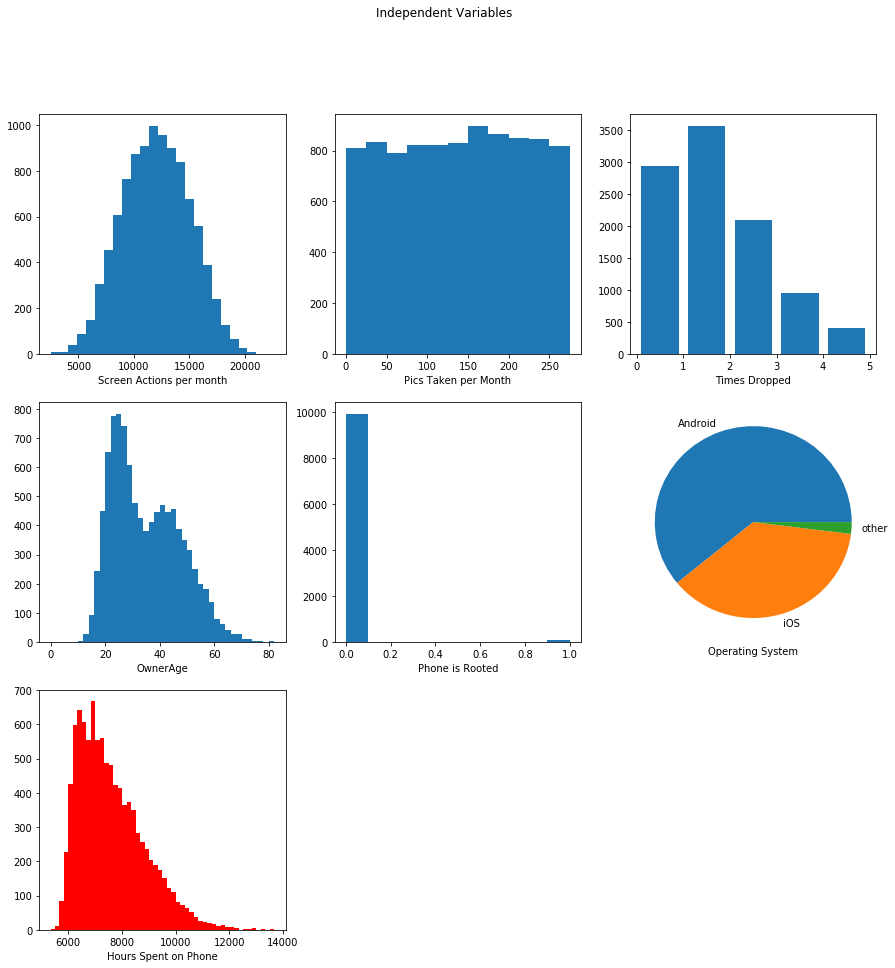

In [488]:
#Core feature Histograms

plt.figure(figsize=(15,15))
plt.suptitle('Independent Variables')
plt.subplot(331)
plt.hist(take.df.screenActions, bins=25)
plt.xlabel('Screen Actions per month')
plt.subplot(332)
plt.hist(take.df.picsPerMonth, bins=np.arange(0,max(u.df.picsPerMonth),25))
plt.xlabel('Pics Taken per Month')
plt.subplot(333)
plt.hist(take.df.timesDropped, bins=np.arange(0,max(u.df.timesDropped),1), rwidth = .8)
plt.xlabel('Times Dropped')
plt.subplot(334)
plt.hist(take.df.ownerAge, bins=np.arange(0,max(u.df.ownerAge),2))
plt.xlabel('OwnerAge')
plt.subplot(335)
plt.hist(take.df.rooted)#, bins=np.arange(0,40,3))
plt.xlabel('Phone is Rooted')
plt.subplot(336)
take.df['os'].value_counts().plot(kind='pie')
plt.xlabel('Operating System')
plt.ylabel('')
plt.subplot(337)
plt.hist(take.df.hoursSpent, color='r', bins=50)#, bins=np.arange(0,40,3))
plt.xlabel('Hours Spent on Phone')

plt.show()







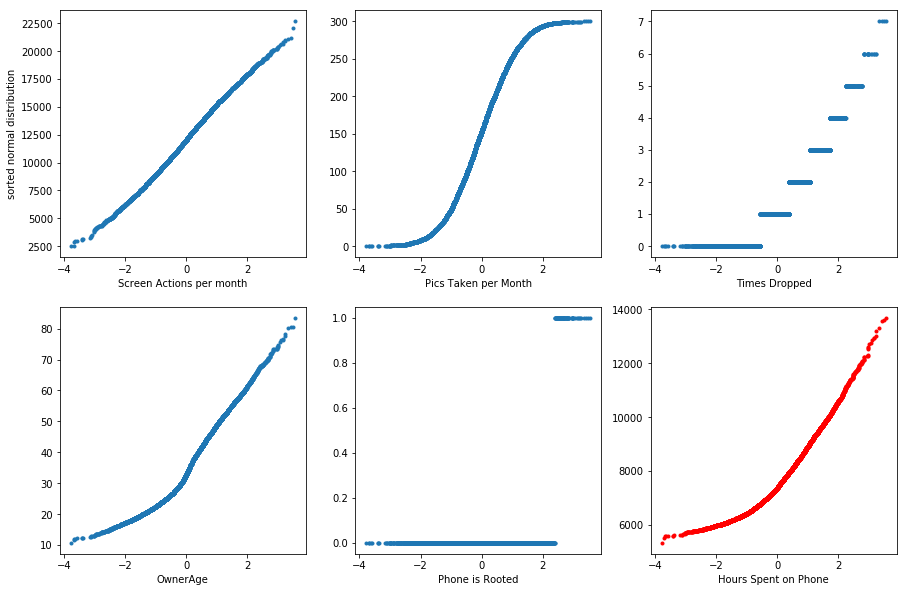

In [489]:
#Quartile Plot compared to random normal

norm = np.random.normal(0, 1, take.size)
norm.sort()
norm1 = take.df['screenActions'].sort_values()
uni2 =  take.df['picsPerMonth'].sort_values()
pois3 =  take.df['timesDropped'].sort_values()
gamma4 = take.df['ownerAge'].sort_values()
bern = take.df['rooted'].sort_values()
target = take.df['hoursSpent'].sort_values()

plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(norm, norm1, ".")
plt.ylabel('sorted normal distribution')
plt.xlabel('Screen Actions per month')
plt.subplot(232)
plt.plot(norm, uni2, ".")
plt.xlabel('Pics Taken per Month')
plt.subplot(233)
plt.plot(norm, pois3, ".")
plt.xlabel('Times Dropped')
plt.subplot(234)
plt.plot(norm, gamma4, ".")
plt.xlabel('OwnerAge')
plt.subplot(235)
plt.plot(norm, bern, ".")
plt.xlabel('Phone is Rooted')
plt.subplot(236)
plt.plot(norm, target, "r.")
plt.xlabel('Hours Spent on Phone')
plt.show()